# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Целью данной работы** является подбор модели с наибольшей точностью, а также её параметров для решения задачи бинарной классификации - подбора одного из двух тарифов для пользователей на основе информации о звонках. Для этого необходимо:

- Изучить входные данные, рассмотреть общую картину;
- Подготовить исходную выборку для дальнейшего обучения и проверки точности модели на валидационных и тестовых данных;
- Провести подбор гиперпараметров модели с целью нахождения модели с максимальной точностью;
- Выбрать модель с максимальной точностью на тестовых данных.

## Откройте и изучите файл

В первую очередь необходимо добавить необходимые инструменты для обработки данных, оценки необходимых метрик и создания и обучения моделей:

In [1]:
# Модели
from sklearn.dummy import DummyClassifier # Base line модель
from sklearn.tree import DecisionTreeClassifier # дерево решений
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия

# Инструменты для работы с моделями
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # подбор гиперпараметров
from sklearn.model_selection import train_test_split # разделение данных на выборки
from sklearn.metrics import accuracy_score # оценка точности
from scipy.stats import uniform # для создания распределений

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas для работы с таблицами
import pandas as pd

# Progress bar для циклов
from tqdm.notebook import tqdm

Считываем данные из csv в DataFrame и выводим на экран

In [2]:
try:
    tariff_data = pd.read_csv('users_behavior.csv')
except:
    tariff_data = pd.read_csv('/datasets/users_behavior.csv')
tariff_data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Общая информация о представленных данных

In [3]:
tariff_data.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
tariff_data.describe().T # статистические метрики

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


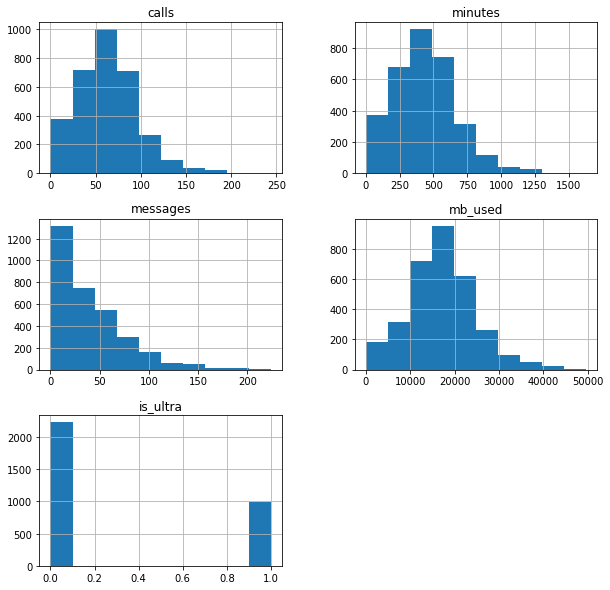

In [5]:
tariff_data.hist(figsize=(10,10)) # гистограммы
plt.show()

**Вывод**: файл прочитан и изучен, представлены его основные метрики а также на гистограммах отражены распределения данных.

## Разбейте данные на выборки

В рамках этой задачи мы лишены тестовых данных, результат для которого заранее неизвестен. В таком случае имеет смысл разбить всю выборку в соотношении 3:1:1, то есть выделить на обучающие данные 60 % выборки, а на тестовые и валидационные - по 20 %. Валидационные данные необходимы для корректировки параметров модели с целью обеспечения лучших результатов, затем модель будет проверена на тестовых данных.

In [6]:
# Выделим из данных признаки
features = tariff_data.drop(['is_ultra'], axis=1)
# и целевой признак
target = tariff_data['is_ultra']
seed = 45012 # данное значение будет определять псевдослучайные последовательности для моделей

Для разбиения выборки применим функцию **train_test_split**, которая разделит наши данные в необходимых пропорциях. После первого использования данные разделены в соотношении 60/40, поэтому на 2 этапе мы разбиваем их напополам. Параметру *stratify* мы присваиваем Series, содержащий целевой параметр, чтобы значения в этих выборках были распределены в том же соотношении, как и в исходном DataFrame.

In [7]:
# делим данные на обучающую и проверочную выборки в соотношении 60/40
df_train, df_testvalid = train_test_split(tariff_data, test_size=.4, random_state=seed, stratify=target)
# делим проверочную выборку на тестовую и валидационную 50/50
df_test, df_valid = train_test_split(df_testvalid, test_size=.5, random_state=seed, stratify=df_testvalid['is_ultra'])

# для каждой группы отделяем целевой признак от всех остальных
# обучающие данные
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
# валидационные данные
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
# тестовые данные
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

Выведем каждую выборку

In [8]:
features_train

,calls,minutes,messages,mb_used
1464,55.0,440.66,85.0,15962.01
2708,45.0,296.26,75.0,13121.85
148,38.0,268.76,0.0,27833.64
707,61.0,396.32,0.0,36298.13
832,55.0,345.49,16.0,20124.93
...,...,...,...,...
2182,86.0,553.93,51.0,13830.48
1984,43.0,311.88,65.0,13085.46
3125,111.0,782.50,51.0,38798.13
1881,62.0,429.23,30.0,19204.57


In [9]:
target_train

1464    1
2708    0
148     1
707     1
832     0
       ..
2182    0
1984    0
3125    1
1881    0
1228    0
Name: is_ultra, Length: 1928, dtype: int64

In [10]:
features_valid

,calls,minutes,messages,mb_used
3034,103.0,711.94,42.0,16667.97
3212,64.0,462.32,90.0,31239.78
2011,83.0,670.68,54.0,19679.78
7,15.0,132.40,6.0,21911.60
2994,82.0,629.14,29.0,15475.25
...,...,...,...,...
1246,104.0,691.93,14.0,34064.29
2277,49.0,336.33,130.0,9777.89
2835,16.0,107.72,16.0,5289.33
132,52.0,378.64,51.0,12442.04


In [11]:
target_valid

3034    0
3212    0
2011    0
7       0
2994    0
       ..
1246    1
2277    1
2835    0
132     0
748     0
Name: is_ultra, Length: 643, dtype: int64

In [12]:
features_test

,calls,minutes,messages,mb_used
511,32.0,182.45,13.0,16552.76
2380,63.0,472.74,40.0,23709.86
1023,76.0,601.10,0.0,17104.36
523,102.0,658.41,23.0,21392.68
3025,63.0,382.32,42.0,18134.87
...,...,...,...,...
1008,46.0,317.98,31.0,16087.51
3075,39.0,278.79,21.0,11430.52
2444,71.0,528.33,17.0,19918.66
620,76.0,484.27,49.0,10474.86


In [13]:
target_test

511     0
2380    0
1023    0
523     0
3025    0
       ..
1008    0
3075    0
2444    0
620     0
726     0
Name: is_ultra, Length: 643, dtype: int64

В цикле проверим баланс классов и размеры полученных выборок целевого признака и в оригинальном DataFrame

In [14]:
[print(x.value_counts(normalize=True),'\nРазмер выборки',x.shape, '\n')
 for x in [target_train, target_valid, target_test]]

0    0.693465
1    0.306535
Name: is_ultra, dtype: float64 
Размер выборки (1928,) 

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64 
Размер выборки (643,) 

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64 
Размер выборки (643,) 



[None, None, None]

In [15]:
tariff_data.is_ultra.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Как видим, баланс классов по целевому признаку сохранён во всех выборках и совпадает с исходным распределением.

**Вывод**: с помощью функции **train_test_split** исходные данные были распределены на 3 группы выборок - тренировочная, вылидационная и тестировочная в соотношении 3:1:1. Первая выборка будет использоваться для обучения модели, вторая - для корректировки её гиперпараметров, а третья - для оценки обучения модели в целом.

## Исследуйте модели

После того, как выборки были подготовлены к дальнейшему использованию можно приступать к обучению моделей. В рамках задания будут рассмотрены модели, изученные ранее - дерево решений, случайный лес и логистическая регрессия. Использование этих моделей обусловлено формулировкой задачи, а именно предмсказания одного из тарифов для пользователей, то есть налицо бинарная классификация. 
В каждой модели я буду использовать 2 варианта подбора гиперпараметров:
*V1* - перебор наиболее важных параметров в цикле, 
*V2* - подбор гиперпараметров встроенными инструментами библиотеки sklearn.

### Дерево решений

#### V1

Саму модель дерева решений, её максимальную глубину и также значение accuracy, по которому будет оцениваться эта модель будет результатом работы функции **decision_tree_model**. Варьируемым параметром выступает максимальная глубина дерева, задаваемая на входе как *depth*.

In [16]:
def decision_tree_model(depth, X, y):
    model = DecisionTreeClassifier(random_state=seed, max_depth=depth) # задаём модель
    model.fit(features_train, target_train) # обучаем её на обучающих данных
    return model.score(X, y), depth, model

In [17]:
trees_valid = [decision_tree_model(depth, features_valid, target_valid) for depth in tqdm(range(1,51))]
trees_train = [decision_tree_model(depth, features_train, target_train) for depth in tqdm(range(1,51))]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Поскольку варьируемый параметр всего 1, то зависимость точности модели от глубины дерева можно отразить на графике. Глубина *depth* Принимает значения от 1 до 50, а значения accuracy берутся с 0 позиции в кортеже значений, возвращаемом функцией **decision_tree_model**.

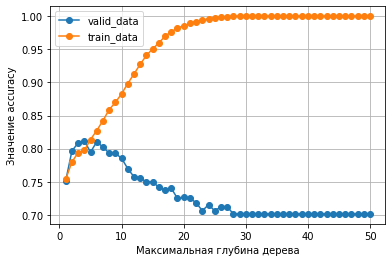

In [18]:
# Рисуем графики для валидационной и тренировочной выборок
plt.plot(
    range(1,51),
    [tree[0] for tree in trees_valid],
    "-o",
    label='valid_data'
)
plt.plot(
    range(1,51),
    [tree[0] for tree in trees_train],
    "-o",
    label='train_data'
)
# добовляем оформление графиков
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Значение accuracy')
plt.grid(True)
plt.legend()
plt.show()

Из графика следует, что модель с ростом максимальной глубины дерева точность модели на тренеровочных данных растёт, а на валидационных падает и максимум наблюдается, если значение глубины не превышает 5. Перебором определим точное значение максимума и присвоим данные лучшей модели соответствующим переменным.

In [19]:
# находим модель с максимальным accuracy и сохраняем её параметры
best_dt_accuracy, best_dt_depth, best_dt_model = max(trees_valid)
print('Максимальная accuracy для валидационных данных модели %s составляет %.4f' % (best_dt_model,best_dt_accuracy))

Максимальная accuracy для валидационных данных модели DecisionTreeClassifier(max_depth=4, random_state=45012) составляет 0.8118


#### V2

В этом разделе варьирование гиперпараметров модели будем проводить с помощью встроенных инструментов: RandomizedSearchCV - подбирает лучший набор случайным образом из заданного набора параметров, GridSearchCV - рассматривает лучший вариант путём перебора всех комбинаций параметров. В отличие от перебора в цикле, такими способами можно рассмотреть больше вариаций параметров, но стоит помнить, что оценкой этих параметров служит max accuracy на **обучающих данных**, а не на валидационных, поэтому оценка для этой выборки может быть меньше.

In [20]:
# определяем проверяемую модель и список параметров, которые будем перебирать 
base_model = DecisionTreeClassifier(random_state=seed)
params = {
    'criterion': ['gini', 'entropy'], # критерий измерения качества
    'max_depth': range(1, 11), # максимальная глубина дерева  
    'min_samples_leaf': range(1,6), # минимальное число 'листов' в конченых узлах
    'min_samples_split': range(2,6) # минимальное число узлов
}

In [21]:
# применяем функцию рандомного поиска
clf_random_tree = RandomizedSearchCV(
    estimator=base_model, # наша модель
    param_distributions=params, # распределение параметров(равномерное, если они заданы списком)
    random_state=seed, # псевдослучайная последовательность
    n_iter=100, # размер случайной выборки
    scoring='accuracy', # параметр, по которому выбирается наилучшая модель(для обучающих данных!)
    n_jobs=-1 # используем все ядра процессора для расчёта
)

В результате своей работы функция случайного поиска нашла следующие параметры наилучшими

In [22]:
print('Лучшие параметры для модели', clf_random_tree.fit(features_train, target_train).best_params_)
print('Точность модели на валидационных данных составляет', clf_random_tree.score(features_valid, target_valid))
print('Точность модели на обучающих данных составляет', clf_random_tree.score(features_train, target_train))

Лучшие параметры для модели {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 9, 'criterion': 'entropy'}
Точность модели на валидационных данных составляет 0.7853810264385692
Точность модели на обучающих данных составляет 0.8443983402489627


Для сеточного поиска

In [23]:
# применяем функцию сеточного поиска
clf_grid_tree = GridSearchCV(
    estimator=base_model, param_grid=params, scoring='accuracy', n_jobs=-1
)

In [24]:
print('Лучшие параметры для модели', clf_grid_tree.fit(features_train, target_train).best_params_)
print('Точность модели на валидационных данных составляет', clf_grid_tree.score(features_valid, target_valid))
print('Точность модели на обучающих данных составляет', clf_grid_tree.score(features_train, target_train))

Лучшие параметры для модели {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Точность модели на валидационных данных составляет 0.7947122861586314
Точность модели на обучающих данных составляет 0.8246887966804979


### Случайный лес

Случайный лес представляет собой множественную структуру дерева решений, поэтому и гиперпараметров у него больше. В этом случае сеточный поиск лучше не использовать, поскольку число комбинаций параметров крайне велико.

#### V1

Подход в данном случае аналогичен предыдущему, однако здесь мы будем варьировать количество деревьев(от 1 до 30) и максимальную глубину каждого из них(от 1 до 10).

In [25]:
def random_forest_model(est, depth, X, y):
    model = RandomForestClassifier(random_state=seed, n_estimators=est, max_depth=depth)
    model.fit(features_train, target_train)
    return model.score(X, y), est, depth, model

In [26]:
# находим модель с максимальным accuracy и сохраняем её параметры
best_rf_accuracy, best_rf_est, best_rf_depth, best_rf_model = max(
    [random_forest_model(est, depth, features_valid, target_valid) for est in tqdm(range(1,31)) for depth in range(1,11)]
)
print('Максимальная accuracy для валидационных данных модели %s составляет %.4f' % (best_rf_model,best_rf_accuracy))

  0%|          | 0/30 [00:00<?, ?it/s]

Максимальная accuracy для валидационных данных модели RandomForestClassifier(max_depth=7, n_estimators=27, random_state=45012) составляет 0.8227


#### V2

In [27]:
# определяем проверяемую модель и список параметров, которые будем перебирать
base_model = RandomForestClassifier(random_state=seed)
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(10, 51, 10), # число деревьев в 'лесу'
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': range(1,6),       
    'min_samples_split': range(2,6)
}

In [28]:
# применяем функцию рандомизированного поиска
clf_random_rf = RandomizedSearchCV(
    estimator=base_model, param_distributions=params, random_state=seed, n_iter=100, scoring='accuracy', n_jobs=-1
)

Результаты поиска

In [29]:
print('Лучшие параметры для модели', clf_random_rf.fit(features_train, target_train).best_params_)
print('Точность модели на валидационных данных составляет', clf_random_rf.score(features_valid, target_valid))
print('Точность модели на обучающих данных составляет', clf_random_rf.score(features_train, target_train))

Лучшие параметры для модели {'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 8, 'criterion': 'entropy'}
Точность модели на валидационных данных составляет 0.8180404354587869
Точность модели на обучающих данных составляет 0.8511410788381742


### Логистическая регрессия

#### V1

В качестве варьируемых параметров рассмотрим тип решателя и число итераций(от 100 до 5000 с шагом 100)

In [30]:
def logistic_regression_model(iter_num, sol):
    model = LogisticRegression(random_state=seed, solver=sol, max_iter=iter_num)
    model.fit(features_train, target_train)
    return model.score(features_valid, target_valid), sol, iter_num, model

**Примечание**: в ходе перебора возникает большое количество предупреждений о том, что алгоритм не сходится, поэтому отсев происходит только для значений, которые удалось рассчитать.

In [31]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # список доступных решателей
best_lr_accuracy, sol, best_lr_iter_num, best_lr_model = max(
    [logistic_regression_model(num, sol) for num in tqdm(range(100,5001,100)) for sol in solvers]
)

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/sklearn/linear_mo

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/scipy/o

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(ms

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(ms

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', Li

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', Li

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_l

In [32]:
print('Максимальная accuracy для валидационных данных модели %s составляет %.4f' % (best_lr_model,best_lr_accuracy))

Максимальная accuracy для валидационных данных модели LogisticRegression(max_iter=5000, random_state=45012, solver='newton-cg') составляет 0.7543


#### V2

In [33]:
# Задаём модель и параметры, которые будем комбинировать
base_model = LogisticRegression(random_state=seed, max_iter=5000)
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': uniform(loc=0, scale=4), # Мощность обратной регуляризации?
    'fit_intercept': [True, False], # добавление/исключение влияния константы на решение
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # тип решателя
}

In [34]:
# применяем рандомизированный поиск
clf_random_lr = RandomizedSearchCV(
    estimator=base_model, param_distributions=params, random_state=seed, n_iter=100, scoring='accuracy', n_jobs=-1
)

In [35]:
print('Лучшие параметры для модели', clf_random_lr.fit(features_train, target_train).best_params_)
print('Точность модели на валидационных данных составляет', clf_random_lr.score(features_valid, target_valid))
print('Точность модели на обучающих данных составляет', clf_random_lr.score(features_train, target_train))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorith

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packag

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-te

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitF

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validatio

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The sco

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitF

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/m

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validatio

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitF

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-te

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Лучшие параметры для модели {'C': 3.6545118312364826, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Точность модели на валидационных данных составляет 0.7542768273716952
Точность модели на обучающих данных составляет 0.7510373443983402


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.7365359         nan 0.74327165 0.70643025 0.74327165
 0.70643025 0.70695108 0.74327165        nan 0.70746921        nan
        nan 0.74327165        nan        nan        nan 0.70746921
        nan        nan 0.70902631 0.70331741 0.70643025        nan
        nan        nan        nan 0.70746921 0.70643025 0.70331741
        nan        nan 0.70331741        nan        nan        nan
        nan 0.70331741        nan        nan 0.70902631        nan
 0.70331741 0.70746921 0.70643025 0.7064316         nan        nan
 0.70331741 0.7095431         nan 0.70331741 0.70643025 0.70746921
        nan 0.74327165 0.70643025        nan 0.70643025 0.70643025
        nan        nan 0.70746921        nan        nan        nan
 0.70643025        nan 0.70746921 0.70331741        nan 0.70331741
        nan 0.70331741 0.7064316  0.70643025 0.70695108 0

**Вывод**:
В рамках данного раздела были исследованы 3 модели для классификации подходящего пользователю тарифа. Подбор гиперпараметров проводился с помощью перебора в цикле малого числа гиперпараметров и с помощью инструментов библиотеки sklearn.model_selection для большого количества параметров. В каждой модели использовался рандомизированный поиск и там, где это возможно за небольшое время - сеточный.В результате подбора гиперпараметров получены следующие результаты:

- ***дерево решений***: для данной модели эффективным оказался перебор максимальной глубины дерева в цикле при сохранении остальных гиперпараметров, максимальное значение accuracy составило 0.8118 при *max_depth*=4 против 0.785 при случайном поиске и 0.795 при сеточном поиске.
- ***случайный лес***: перебор даёт accuracy 0.8227 при 27 деревьях с глубиной 7 и 0.818 при рандомизированном подборе гиперпараметров.
- ***логистическая регрессия***: самые низкие значения accuracy относительно других моделей - 0.7543, как при переборе так и в рандомизированном поиске, поэтому в самой простой модели достаточно сменить решатель на 'newton-cg' и ограничить количество итераций 5000.

Наивысшая оценка по валидационной выборке у случайного леса с параметрами max_depth=7, n_estimators=27.

## Проверьте модель на тестовой выборке

Обычно этот этап необходим для того, чтобы оценить модель в реальных условиях, когда ответы для клиентов с разным набором данных заранее неизвестны. В нашем случае аналогом таких данных выступает тестовая выборка. соберём все полученные модели и результаты в одну таблицу.

In [36]:
# список рассмотренных моделей
models_list = [best_dt_model, clf_random_tree, clf_grid_tree, best_rf_model, clf_random_rf, best_lr_model, clf_random_lr]
# собираем результаты моделирования в один DataFrame
result_table = pd.DataFrame({
    'model_type': [
        'DecisionTree', 'DecisionTree', 'DecisionTree',
        'RandomForest', 'RandomForest',
        'LinearRegression', 'LinearRegression'],
    'param_choise_type': ['V1', 'V2_random', 'V2_grid', 'V1', 'V2_random', 'V1', 'V2_random'],
    'valid_accuracy': [model.score(features_valid, target_valid) for model in models_list],
    'test_accuracy': [model.score(features_test, target_test) for model in models_list]
}, index=['DT_V1', 'DT_V2_rnd', 'DT_V2_grid', 'RF_V1', 'RF_V2_rnd', 'LR_V1', 'LR_V2_rnd']
)
# выводим DataFrame с сортировкой по убыванию на тестовой выборке
result_table.sort_values(by='test_accuracy', ascending=False)

,model_type,param_choise_type,valid_accuracy,test_accuracy
RF_V1,RandomForest,V1,0.822706,0.818040
RF_V2_rnd,RandomForest,V2_random,0.818040,0.813375
DT_V1,DecisionTree,V1,0.811820,0.791602
DT_V2_grid,DecisionTree,V2_grid,0.794712,0.790047
DT_V2_rnd,DecisionTree,V2_random,0.785381,0.788491
LR_V1,LinearRegression,V1,0.754277,0.741835
LR_V2_rnd,LinearRegression,V2_random,0.754277,0.741835


Для более наглядного представления acсuracy построим по этим данным heatmap

<AxesSubplot:>

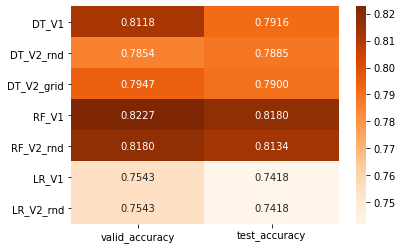

In [37]:
sns.heatmap(data=result_table.loc[:,'valid_accuracy':'test_accuracy'], cmap='Oranges', annot=True, fmt=".4f")

**Вывод**: Итоговые результаты по тестовой выборки следующие:
1. Случайный лес с перебором параметров в цикле(RF_V1) - 0.8180;
2. Случайный лес и случайный подбор гиперпараметров(RF_V2_rnd) - 0.8134;
3. Дерево решений с перебором параметров в цикле(DT_V1) - 0.7916.

Самые низкие результаты показали модели логистической регрессии - в обоих случаях 0.7418.

## (бонус) Проверьте модели на адекватность

Проверки наших моделей на адекватность будем осуществлять посредством сравнения с base line моделью, являющейся наиболее простым вариантом решения. Если accuracy такой модели превосходит acuuracy сложных вариантов, то их нельзя считать адекватными по точности.

In [38]:
# задаём параметры модели и обучаем её
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=seed)
dummy_clf.fit(features_train, target_train)

DummyClassifier(random_state=45012, strategy='most_frequent')

In [39]:
print('Точность модели на обучающих данных составляет', dummy_clf.score(features_train, target_train))
print('Точность модели на валидационных данных составляет', dummy_clf.score(features_valid, target_valid))
print('Точность модели на тестовых данных составляет', dummy_clf.score(features_test, target_test))

Точность модели на обучающих данных составляет 0.6934647302904564
Точность модели на валидационных данных составляет 0.6936236391912908
Точность модели на тестовых данных составляет 0.6936236391912908


**Вывод**: Значение accuracy для всех моделей превышает это значение на тестовой выборке, поэтому можно заключить, что все они адекватны.

## Выводы

В данной работе проведено изучение различных моделей для решения задачи бинарной классификации - предсказания одного из тарифов на основе информации о пользователе. По результатам работы можно заключить следующее:
1. Изучены входные данные для использования моделей, предоставлена необходимая информация и графики
2. Исходные данные разделены на 3 выборки: обучающую - 60 %, валидационную - 20 % и тестовую - 20 % причём распределение данных в них соответствует исходной выборке.
3. Рассмотрены 3 модели - дерево решений, случайный лес и логистическая регрессия, гиперпараметры в них подбирались 2 различными способами: перебором в цикле и функциями рандомизированного и сеточного поиска.
4. Перебор в цикле показывает хорошие результаты, если исследовать 1-2 параметра, в ином случае лучше использовать рандомизированный поиск, поскольку он может проверять комбинации множества параметров без существенных затрат времени.
5. Лучшими оказались модели случайного леса и дерева решений, для них accuracy больше 0.79, причём самым лучшим алгоритмом на тестовых данных оказался случайный лес с 27 деревьями с максимальной глубиной 7, а для дерева решений следует выбирать максимальную глубину = 4.
6. Самые слабые модели в рамках этой задачи - логистическая регрессия, её accuracy на тестовых данных меньше 0.75
7. Несмотря на это, все модели прошли проверку на адекватность base line моделью.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
